# Starts Pipeline

In [ ]:
# Ruta donde se guardarán los resultados
ruta = '/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5'

## Lectura de los datos

In [ ]:
# Lectura de la serie de entrada ya imputada e interpolada
series_entrada = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Bases_datos_finales_modelostesis/Precios_entrada_MM_WTI_ArticuloQ1/precios_pet_MezclaMexicana_WTI_abril.xlsx', index_col=0)

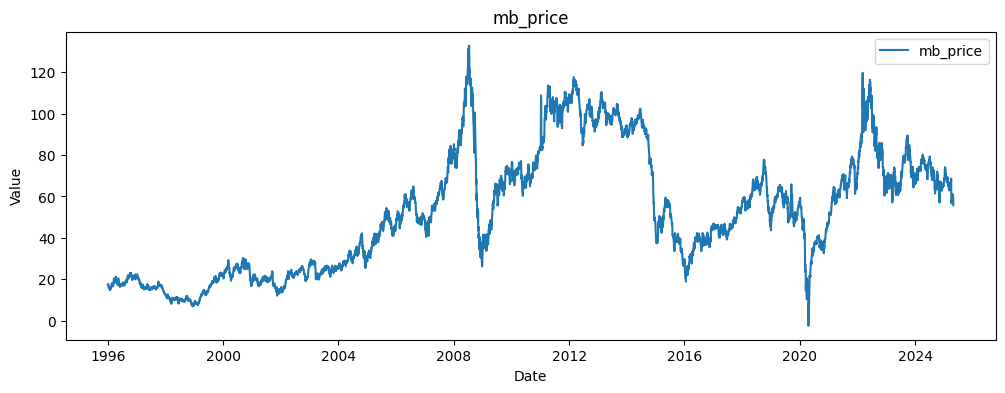

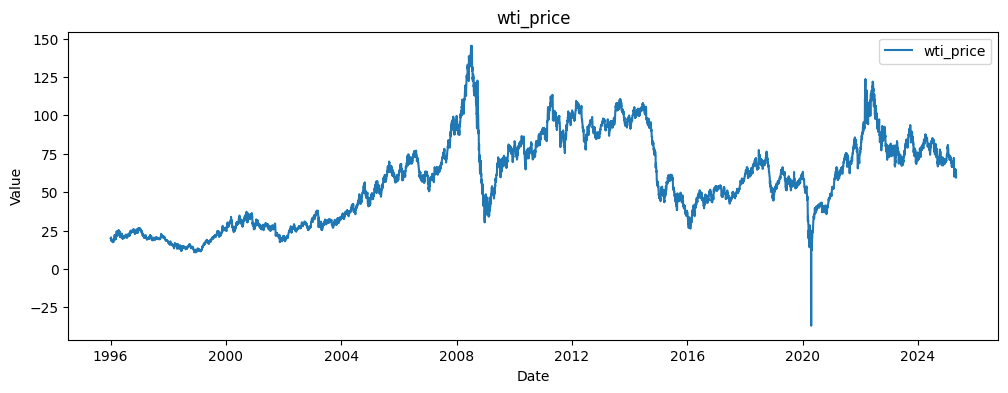

In [ ]:
# Visualización de las series
plot_series(series_entrada)

In [ ]:
# Verificación de índices temporales
for series in series_entrada:
    verificar_indice_temporal(series_entrada[series], nombre={series})

📊 Verificando índice temporal de: {'mb_price'}
------------------------------------------------------------
✅ Índice tipo DatetimeIndex
⏱ Fechas: 1996-01-03 ➡️ 2025-04-30
🔁 Frecuencia declarada: None
🧪 Frecuencia inferida: B
⬆️ Índice creciente: True
Longitud de la serie: 7651
✅ Índice sin NaN.
------------------------------------------------------------
📊 Verificando índice temporal de: {'wti_price'}
------------------------------------------------------------
✅ Índice tipo DatetimeIndex
⏱ Fechas: 1996-01-03 ➡️ 2025-04-30
🔁 Frecuencia declarada: None
🧪 Frecuencia inferida: B
⬆️ Índice creciente: True
Longitud de la serie: 7651
✅ Índice sin NaN.
------------------------------------------------------------


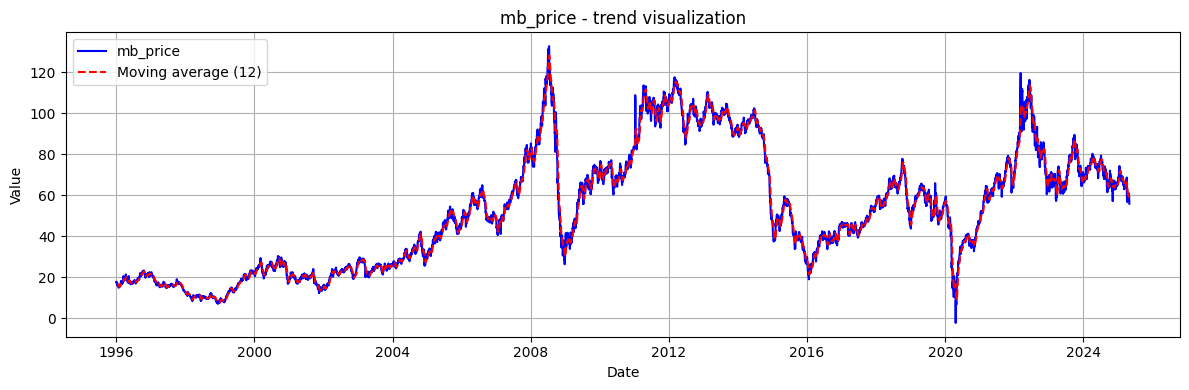

📉 Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba       -2.345968
Valor p                      0.157571
# Lags usados               17.000000
# Observaciones usadas    7633.000000
Valor crítico (1%)          -3.431207
Valor crítico (5%)          -2.861919
Valor crítico (10%)         -2.566972
dtype: float64
❌ La serie **NO** es estacionaria (p ≥ 0.05)


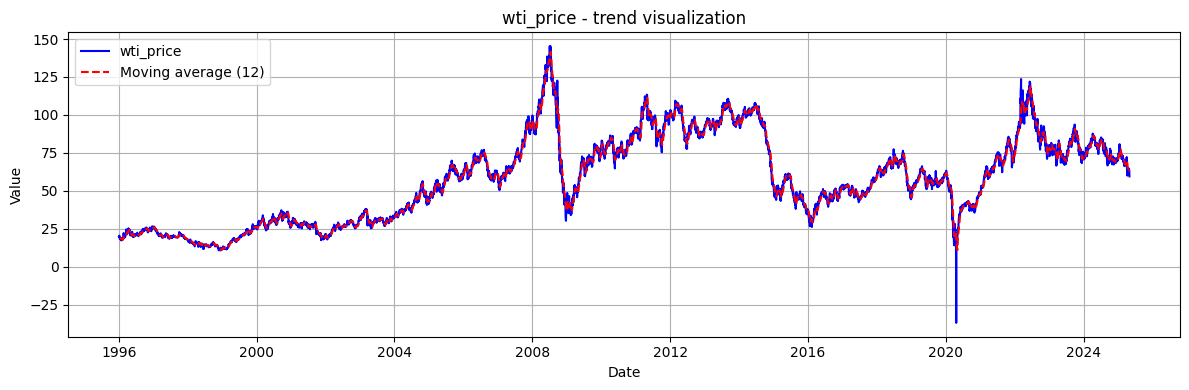

📉 Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba       -2.623972
Valor p                      0.088143
# Lags usados               30.000000
# Observaciones usadas    7620.000000
Valor crítico (1%)          -3.431208
Valor crítico (5%)          -2.861919
Valor crítico (10%)         -2.566972
dtype: float64
❌ La serie **NO** es estacionaria (p ≥ 0.05)


In [ ]:
# Prueba de estacionariedad
for series in series_entrada:
  result_estacionariedad, p = test_stationarity(series_entrada[series], title=series)

## Guardar series objetivos originales

In [ ]:
# Extraer serie(s) original(s) y objetivo(s)
# *Se usará en pasos futuros
serie_original = pd.DataFrame(series_entrada['mb_price'])
print(type(serie_original))
print(serie_original.shape)

<class 'pandas.core.frame.DataFrame'>
(7651, 1)


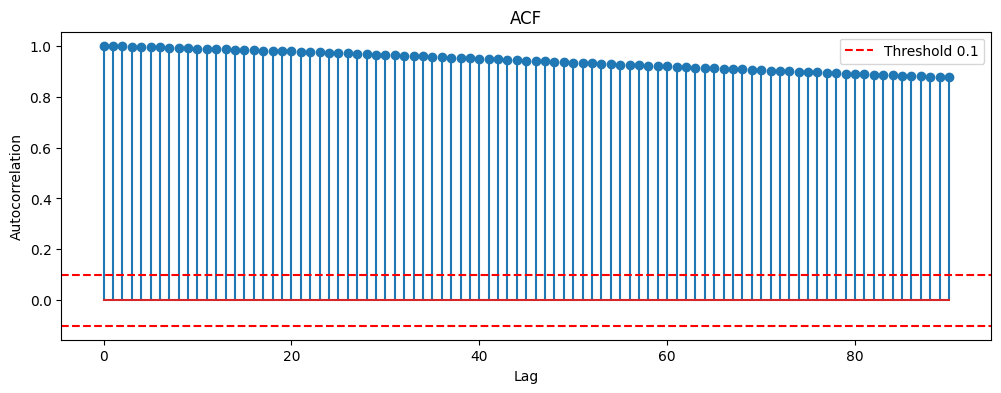

Memoria efectiva L_s = 90
Lag óptimo para horizonte (5) = 5


In [ ]:
# Elección del lag óptimo para calcular la dependencia temporal lag_h como característica adicional, escenario S1
horizon = 5  # horizonte deseado
for col_name in serie_original.columns:
    lag_h, memoria, acf_vals = seleccionar_lag_optimo(serie_original[col_name], horizon)

print(f"Memoria efectiva L_s = {memoria}")
print(f"Lag óptimo para horizonte ({horizon}) = {lag_h}")

## Split de los datos

In [ ]:
# Split de los datos
train_series, val_series, test_series, end_dates = dividir_series(serie_original, proporcion_validacion=0.15)

In [ ]:
# Visualización rápida de los splits
train_series.head()

,mb_price
date,
1996-01-03,17.40
1996-01-04,17.41
1996-01-05,17.70
1996-01-08,17.54
1996-01-09,17.41


In [ ]:
# Verificación de los tamaños
print('Tamaño del conjunto de entrenamiento:', train_series.shape)
print('Tamaño del conjunto de validación:', val_series.shape)
print('Tamaño del conjunto de prueba:', test_series.shape)

Tamaño del conjunto de entrenamiento: (5355, 1)
Tamaño del conjunto de validación: (1147, 1)
Tamaño del conjunto de prueba: (1149, 1)


In [ ]:
def plot_split(train_series, val_series, test_series,
               guardar=True, ruta_guardado=None, nombre_figura="split_plot.png"):
    """
    Grafica la separación train/val/test respetando el índice temporal
    y opcionalmente guarda la figura.
    """

    plt.figure(figsize=(12, 4))

    # Graficar cada segmento respetando su índice (si lo tienen)
    plt.plot(train_series.index, train_series.values, label="train")
    plt.plot(val_series.index, val_series.values, label="val")
    plt.plot(test_series.index, test_series.values, label="test")

    plt.title("Mexican Blend Price — Train / Validation / Test")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.30)
    plt.legend()

    # Guardar figura si corresponde
    if guardar:
        if ruta_guardado is None:
            raise ValueError("Debes proporcionar 'ruta_guardado' si guardar=True.")
        ruta_completa = os.path.join(ruta_guardado, nombre_figura)
        plt.savefig(ruta_completa, dpi=300, bbox_inches="tight")

    plt.show()   # Mostrar primero
    plt.close()  # Cerrar después

In [ ]:
plot_split(train_series, val_series, test_series, guardar=True, ruta_guardado=ruta, nombre_figura='split_serie_mb_price.png')

## Creación de características técnicas
| Variable derivada                                   | Tipo                     | Justificación económica y técnica                                             |
| --------------------------------------------------- | ------------------------ | ----------------------------------------------------------------------------- |
| **Retorno logarítmico (`log return`)**              | Momentum                 | Captura crecimiento porcentual. Escala aditiva. Común en activos financieros. |
| **Diferencia absoluta (`diff`)**                    | Tendencia                | Captura la dirección y magnitud del cambio diario.                            |
| **Media móvil simple (SMA)**                        | Suavizado                | Reduce ruido y revela estructura de tendencia. Relevante para traders.        |
| **Desviación estándar móvil (Volatilidad rolling)** | Volatilidad              | Captura periodos de alta/baja incertidumbre, clave en mercados petroleros.    |
| **Z-score rolling**                                 | Normalización contextual | Detecta valores anómalos relativo a su ventana histórica.                     |
| **Lag 1 y Lag 5**                                   | Dependencia temporal     | Introduce memoria explícita para series autoregresivas.                       |
| **Media exponencial (EMA)**                         | Tendencia reciente       | Pone más peso al pasado cercano, muy usado en análisis técnico.               |
| **Índice RSI** (opcional)                           | Momentum                 | Detecta sobrecompra/sobreventa. No siempre útil en precios agregados diarios. |


## 📌 ¿Qué es la volatilidad GARCH y para qué la usamos?

GARCH (*Generalized Autoregressive Conditional Heteroskedasticity*) es un modelo que permite estimar la **volatilidad condicional** de una serie temporal, es decir, cuánta variabilidad se espera en cada momento del tiempo, dependiendo del comportamiento pasado.

En muchos sistemas financieros, la volatilidad no es constante: hay periodos tranquilos y otros muy volátiles. GARCH nos ayuda a capturar ese comportamiento dinámico.

> 💡 **Recomendación práctica:**  
> Empieza con `'GARCH'` (robusto y estable).  
> Usa `'GJR-GARCH'` o `'APARCH'` si observas asimetrías en los choques de precios.

In [ ]:
'''Evaluación por feature (hold-out 2010–2015)

1. Serie original
2. + log_return
3. + log_return + lag_h
4. + log_return + lag_h + spread   ===*Posible mejor configuración*===
...............................................
5. + log_return + lag_h + spread + rolling_std   =*Usar caracterísicas de volatilidad paraece no dar buenos resultados*=
6. + todas → comparar contra estos

Elección de ventana por característica:

Ventana SMA = horizon a horizon * 4
Ventana rolling = horizon * 3 a horizon * 5 (Volatilidad)
Ventana zscore = horizon * 1.5 a horizon * 3

Máximo practico = 90 días, evitar ventanas > 100
                                                  '''

'Evaluación por feature (hold-out 2010–2015)\n\n1. Sin features\n2. + log_return\n3. + log_return + lag_h\n4. + log_return + lag_h + spread\n...............................................\n5. + log_return + lag_h + spread + rolling_std\n6. + todas → comparar contra estos\n\nElección de ventana por característica:\n\nVentana SMA = horizon a horizon * 2\nVentana rolling = horizon * 3 a horizon * 5 (Volatilidad)\nVentana zscore = horizon * 1.5 a horizon * 3\n\nMáximo practico = 90 días, evitar ventanas > 100\n                                                  '

In [ ]:
# Creación de características de multiples series
# --- Configuración base ---
# Columnas para predecir
columnas_objetivo = (serie_original.columns).tolist()        # ['nombre_objetivo_1', 'nombreobjetivo_2', 'nombreobjetivo_N']

# Pares de spreads a calcular
pares_spread = [('mb_price', 'wti_price')]     # Pares de series relacionadas

# Parámetros comunes (puedes ajustarlos)
params_features = dict(
    columnas_objetivo=columnas_objetivo,
    pares_spread=None,
    ventana_SMA=horizon*4,        # Cuidado de no superar el tamaño de la secuencia (sequence_length)
    ventana_rolling=horizon*4,    # no acepta * .5
    ventana_zscore=horizon*2,
    lag=lag_h,
    calcular_logreturn=False,
    calcular_diff=False,
    calcular_SMA=False,
    calcular_rolling=False,
    calcular_zscore=False,
    calcular_lag=False,
    calcular_spreadfeatures=False,
    usar_vol=False,
    vol='APARCH',
    p=1,
    q=1,
    escala=1.0
)

# Diccionario con los splits
data_splits = {
    'train': train_series,
    'val': val_series,
    'test': test_series
}

# --- Aplicar ingeniería de características a cada split ---
features_splits = {
    k: crea_caracteristicas_multiseries(v, **params_features)
    for k, v in data_splits.items()
}

# --- Acceso rápido individual ---
feat_train = features_splits['train']
feat_val   = features_splits['val']
feat_test  = features_splits['test']

⚠️  No se activó ningún bloque de cálculo; se devuelve el DataFrame original sin nuevas columnas.
⚠️  No se activó ningún bloque de cálculo; se devuelve el DataFrame original sin nuevas columnas.
⚠️  No se activó ningún bloque de cálculo; se devuelve el DataFrame original sin nuevas columnas.


In [ ]:
print(f'última fecha del conjunto de entrenamiendo y prueba validación {end_dates}')

última fecha del conjunto de entrenamiendo y prueba validación (Timestamp('2016-07-12 00:00:00'), Timestamp('2020-12-03 00:00:00'))


In [ ]:
# Verificar cada conjunto de datos
feat_train.describe()

,mb_price
count,5355.000000
mean,48.965983
std,32.134068
min,6.950000
25%,21.355000
50%,39.550000
75%,74.450000
max,132.710000


## **Si se generaron características técnicas correr las celdas de este bloque**

In [ ]:
# Concatenar de nuevo para interpolar (con pasado/sin fuga de información) Nan's de val y test
# Concatenación
#feat_series = pd.concat([feat_train, feat_val, feat_test], axis=0).sort_index()

# Interpolación
#feat_series = feat_series.interpolate(method='linear', limit_direction='forward').ffill(limit=1)
#print(feat_series.shape)
#print(type(feat_series))
#print(feat_series.isna().sum())


****Si hay variables exógenas usar función de concatenación aqui****

In [ ]:
#feat_series = unir_exogenas(
#    df_endogenas = feat_series,
#    df_exogenas = exo_series,
#    align_to = "endogenas",             # "endogenas" | "interseccion" | "union"
#    how = "left",                       # join sobre el índice: "left"|"inner"|"outer"
#    resample_to_endogenas = True,
#    agg = "last",                       # cómo agregar exógenas al remuestrear: "last"|"mean"|"sum"...
#    ffill_exogenas = False,             # solo forward-fill (no backfill) para evitar fuga
#    ffill_limit: None,                  # límite de pasos a rellenar hacia delante
#    enforce_business_days = False,      # reindex a 'B' si quieres calendario laboral
#    add_suffix_to_exogenas =  "_exo",   # sufijo para colisiones de nombres
#   lag_exogenas = None                 # opcional: desplazar exógenas t->t-1.. para evitar “tiempo real” engañoso
#)

In [ ]:
# Eliminamos Nan´s remanentes de train
#feat_series = feat_series.dropna()

#print(feat_series.shape)
#print(type(feat_series))
#print(feat_series.isna().sum())

In [ ]:
# Dividir_serie después de eliminar Nan´s
#feat_train, feat_val, feat_test, end_dates = dividir_series(feat_series, proporcion_validacion=0.15)

In [ ]:
# Verificar visualmente que no haya más Nan's
#feat_train.head()

## Visualización

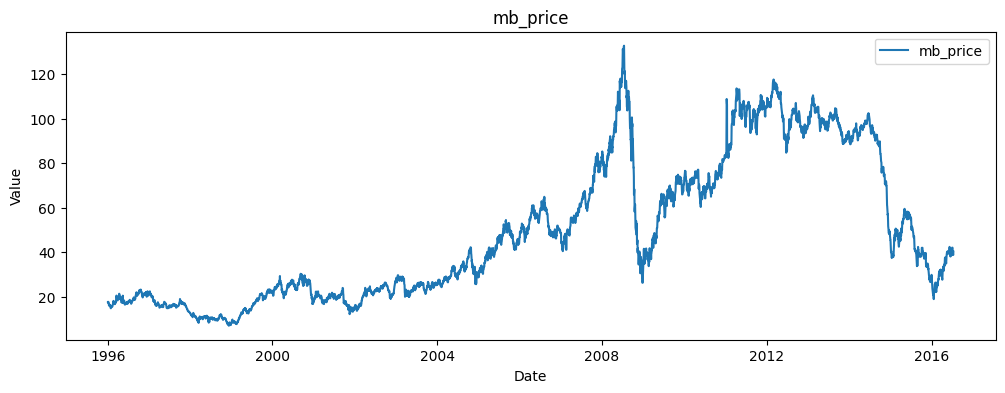

In [ ]:
# Inspección visual de los conjuntos de datos
plot_series(feat_train)

In [ ]:
# Verficación final de los índices temporales
verificar_alineacion_indices(feat_train, feat_val, feat_test)

Train: 1996-01-03 00:00:00 → 2016-07-12 00:00:00 (5355 filas)
Val:   2016-07-13 00:00:00 → 2020-12-03 00:00:00 (1147 filas)
Test:  2020-12-04 00:00:00 → 2025-04-30 00:00:00 (1149 filas)
Frecuencia inferida: B
✅ Val inicia justo después del split anterior (B).
✅ Test inicia justo después del split anterior (B).


In [ ]:
print('Tamaño del conjunto de entrenamiento:', feat_train.shape)
print('Tamaño del conjunto de validación:', feat_val.shape)
print('Tamaño del conjunto de prueba:', feat_test.shape)

Tamaño del conjunto de entrenamiento: (5355, 1)
Tamaño del conjunto de validación: (1147, 1)
Tamaño del conjunto de prueba: (1149, 1)


## Estandarización

In [ ]:
# Estandarización de los conjuntos de datos
train_std_series, val_std_series, test_std_series, scaler = estandarizar_train_test(feat_train, feat_val, feat_test)

In [ ]:
train_std_series.describe()

,mb_price
count,5.355000e+03
mean,-2.547604e-16
std,1.000093e+00
min,-1.307644e+00
25%,-8.593236e-01
50%,-2.930492e-01
75%,7.931270e-01
max,2.606325e+00


In [ ]:
print('Tamaño del conjunto de entrenamiento:', train_std_series.shape)
print('Tamaño del conjunto de validación:', val_std_series.shape)
print('Tamaño del conjunto de prueba:', test_std_series.shape)

Tamaño del conjunto de entrenamiento: (5355, 1)
Tamaño del conjunto de validación: (1147, 1)
Tamaño del conjunto de prueba: (1149, 1)


## Entrenamiento LSTM

In [ ]:
# === Parámetros ===
sequence_length = 90
batch_size = 16
label_cols = [0]
stride = horizon

# === Crear secuencias de series estandarizadas (siempre en CPU y y en 3D) ===
train_sequences, train_labels = create_multichannel_label_sequences(
    train_std_series, sequence_length, label_cols,
    horizon=horizon, stride=stride,
)
val_sequences, val_labels = create_multichannel_label_sequences(
    val_std_series, sequence_length, label_cols,
    horizon=horizon, stride=stride
)
test_sequences, test_labels = create_multichannel_label_sequences(
    test_std_series, sequence_length, label_cols,
    horizon=horizon, stride=stride
)

# === Verificación rápida de shapes ===
print(f"Train sequences: {train_sequences.shape}")  # (N, seq, D)
print(f"Train labels   : {train_labels.shape}")     # (N, H, O)
print(f"Test sequences : {test_sequences.shape}")
print(f"Test labels    : {test_labels.shape}")

print(type(train_sequences))

Train sequences: torch.Size([1053, 90, 1])
Train labels   : torch.Size([1053, 5, 1])
Test sequences : torch.Size([211, 90, 1])
Test labels    : torch.Size([211, 5, 1])
<class 'torch.Tensor'>


In [ ]:
# === Hiperparámetros del modelo ===
input_size = train_sequences.shape[2]
hidden_layer_size = 128
output_size = len(label_cols)
num_layers = 2
dropout = 0.2
learning_rate =7e-4           # 1e-3, 1e-4, si MLP activado probar 7e-4
num_epochs = 500
patience = 80                 # 40 si horizontes<10, 80 si horizonte>10
temporal_readout = "last"     # "last", "mean", o "attn"
query_mode = ('mixed', 0.7)           # Puede ser 'last', 'mean' o ('mixed', #) (# = 0.1 - 1 % de last)
head_dropout = 0.1            # 0.05-0.15
use_layernorm = True
multihead = True
head_type = "mlp"             # 'linear' | 'mlp' | 'lowrank'
mlp_hidden = 32              # None = usa la fórmula automática (Hidden_layer_size//2 = 64)
use_residual_fusion = True    # Fusion residual en el modo de atención seleccionado
beta_param = 0.8              # 0-1

# === Modelo ===
model = Attention_LSTM(
    input_size=input_size,
    hidden_layer_size=hidden_layer_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout,
    multihead=multihead,
    horizon=horizon,
    temporal_readout=temporal_readout,
    query_mode=query_mode,
    head_dropout=head_dropout,
    use_layernorm=use_layernorm,
    head_type = head_type,
    mlp_hidden = mlp_hidden,
    use_residual_fusion = use_residual_fusion,
    beta_param = beta_param
)

# === Entrenamiento ===
model_LSTM, history = entrenar_modelo_avanzado(
    model=model,
    train_sequences=train_sequences,
    train_labels=train_labels,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    patience=patience,
    log_alpha = False,
    log_beta = False,
    val_sequences=val_sequences,
    val_labels=val_labels
)


🟢 Epoch 1/500 - Train: 0.077223 | Val: 0.014090 | grad_norm: 2.481


🟢 Epoch 10/500 - Train: 0.008073 | Val: 0.005107 | grad_norm: 0.265


🟢 Epoch 20/500 - Train: 0.005454 | Val: 0.005393 | grad_norm: 0.192


🟢 Epoch 30/500 - Train: 0.005026 | Val: 0.004168 | grad_norm: 0.196


🟢 Epoch 40/500 - Train: 0.004116 | Val: 0.003492 | grad_norm: 0.145


🟢 Epoch 50/500 - Train: 0.003923 | Val: 0.003224 | grad_norm: 0.151


🟢 Epoch 60/500 - Train: 0.003707 | Val: 0.003463 | grad_norm: 0.145


🟢 Epoch 70/500 - Train: 0.003772 | Val: 0.003556 | grad_norm: 0.136


🟢 Epoch 80/500 - Train: 0.003962 | Val: 0.003206 | grad_norm: 0.147


🟢 Epoch 90/500 - Train: 0.003507 | Val: 0.003284 | grad_norm: 0.120


🟢 Epoch 100/500 - Train: 0.003204 | Val: 0.003017 | grad_norm: 0.099


🟢 Epoch 110/500 - Train: 0.003194 | Val: 0.003013 | grad_norm: 0.095


🟢 Epoch 120/500 - Train: 0.003481 | Val: 0.002921 | grad_norm: 0.116


🟢 Epoch 130/500 - Train: 0.003068 | Val: 0.003157 | grad_norm: 0.101


🟢 Epoch 140/500 - Train: 0.003306 | Val: 0.003707 | grad_norm: 0.106


🟢 Epoch 150/500 - Train: 0.003093 | Val: 0.003480 | grad_norm: 0.100


🟢 Epoch 160/500 - Train: 0.002946 | Val: 0.002752 | grad_norm: 0.088


🟢 Epoch 170/500 - Train: 0.003164 | Val: 0.002966 | grad_norm: 0.095


🟢 Epoch 180/500 - Train: 0.002826 | Val: 0.002632 | grad_norm: 0.083


🟢 Epoch 190/500 - Train: 0.002877 | Val: 0.003212 | grad_norm: 0.089


🟢 Epoch 200/500 - Train: 0.003151 | Val: 0.002680 | grad_norm: 0.093


🟢 Epoch 210/500 - Train: 0.003062 | Val: 0.002898 | grad_norm: 0.095


🟢 Epoch 220/500 - Train: 0.002908 | Val: 0.002913 | grad_norm: 0.101


🟢 Epoch 230/500 - Train: 0.002771 | Val: 0.002616 | grad_norm: 0.085


🟢 Epoch 240/500 - Train: 0.002655 | Val: 0.002658 | grad_norm: 0.072


🟢 Epoch 250/500 - Train: 0.002497 | Val: 0.002898 | grad_norm: 0.072


🟢 Epoch 260/500 - Train: 0.002492 | Val: 0.002642 | grad_norm: 0.076


🟢 Epoch 270/500 - Train: 0.002244 | Val: 0.002586 | grad_norm: 0.058


🟢 Epoch 280/500 - Train: 0.002325 | Val: 0.002801 | grad_norm: 0.066


🟢 Epoch 290/500 - Train: 0.002171 | Val: 0.002596 | grad_norm: 0.061


🟢 Epoch 300/500 - Train: 0.002243 | Val: 0.002603 | grad_norm: 0.061


⏹️ Early stopping activado: no mejora en 80 épocas.


## Evaluación del modelo LSTM



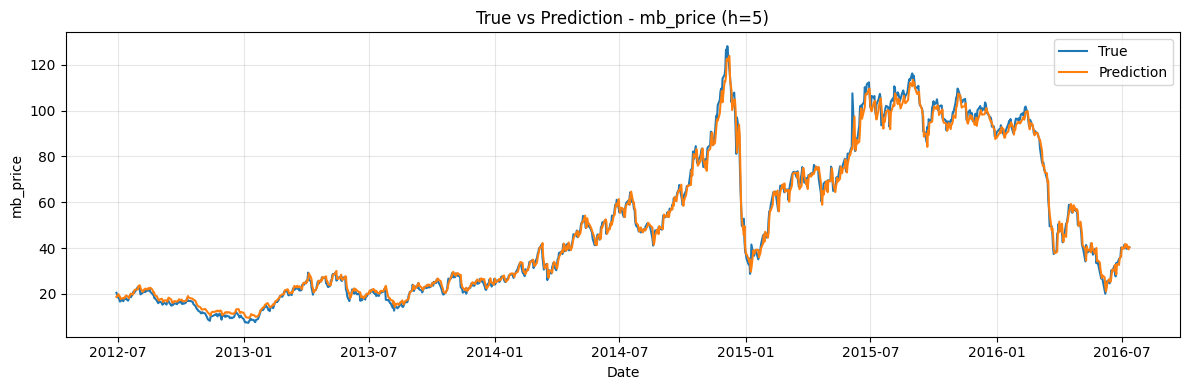

✅ Métricas guardadas en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/metricas_evaluacion_train_No_ARCH_S0_5.xlsx
📄 PDF con predicciones guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/predicciones_train_No_ARCH_S0_5.pdf
   Horizonte  Variable       MAE     RMSE        R2
0          5  mb_price  1.970487  2.77069  0.992552


In [ ]:
vol = 'NA'
id_model = 'S0'

# Asegurar que las fechas se alineen con los labels/predicciones reales
# Ajusta los parámetros del modelo para explicar los patrones del pasado
fechas_train = train_series.index[-len(train_labels):]

# Evaluar modelo sobre el conjunto de entrenamiento
resultados_train, metricas_eva_train, y_real_rec_train, y_pred_rec_train = evaluar_modelo(
    model_LSTM,
    train_sequences,
    train_labels,
    scaler,
    nombres_columnas=list(serie_original.columns),
    label_idx= label_cols,
    plot=True,
    fechas=fechas_train,
    batch_size_eval=batch_size,
    h_idx=horizon-1,
    guardar_predicciones=True,
    guardar_metricas=True,
    ruta_metricas = ruta + f"/metricas_evaluacion_train_{vol}_{id_model}_{horizon}.xlsx",
    ruta_predicciones = ruta + f"/predicciones_train_{vol}_{id_model}_{horizon}.pdf"
)

print(metricas_eva_train)

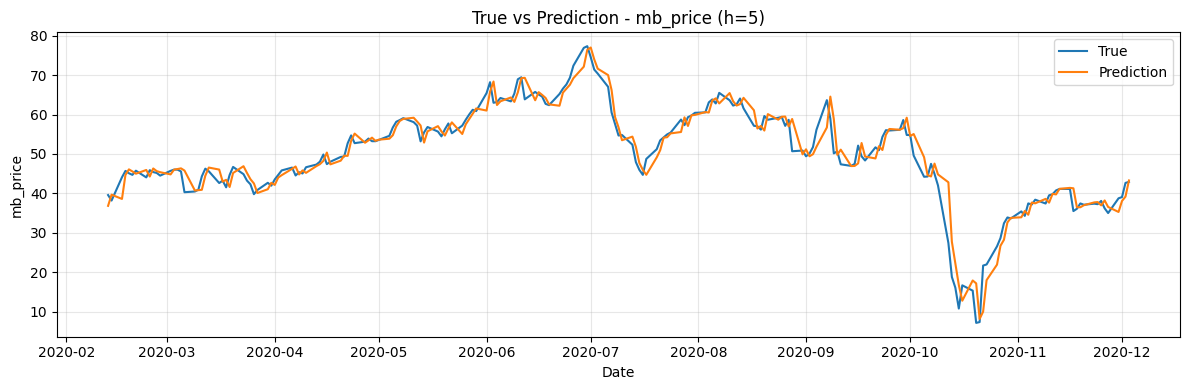

✅ Métricas guardadas en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/metricas_evaluacion_val_No_ARCH_S0_5.xlsx
📄 PDF con predicciones guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/predicciones_val_No_ARCH_S0_5.pdf
   Horizonte  Variable       MAE      RMSE        R2
0          5  mb_price  2.047938  2.944679  0.943384


In [ ]:
# Asegurar que las fechas se alineen con los labels/predicciones reales
fechas_val = val_series.index[-len(val_labels):]
# Seleccionar hiperparámetros y evitar sobreajuste, habilidad para generalizar a
# datos ligeramente nuevos
# Evaluar modelo sobre el conjunto de validación
resultados_val, resultados_eva_val, y_real_rec_val, y_pred_rec_val = evaluar_modelo(
    model_LSTM,
    val_sequences,
    val_labels,
    scaler,
    label_idx= label_cols,
    nombres_columnas=list(serie_original.columns),
    plot=True,
    fechas=fechas_val,
    batch_size_eval=batch_size,
    h_idx=horizon-1,
    guardar_predicciones=True,
    guardar_metricas=True,
    ruta_metricas = ruta + f"/metricas_evaluacion_val_{vol}_{id_model}_{horizon}.xlsx",
    ruta_predicciones = ruta + f"/predicciones_val_{vol}_{id_model}_{horizon}.pdf"
)

print(resultados_eva_val)

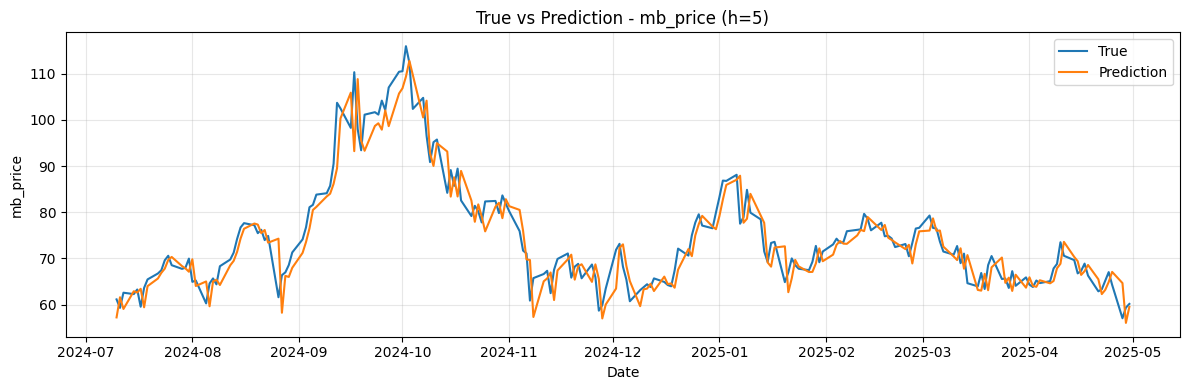

✅ Métricas guardadas en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/metricas_evaluacion_test_No_ARCH_S0_5.xlsx
📄 PDF con predicciones guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/predicciones_test_No_ARCH_S0_5.pdf
   Horizonte  Variable       MAE      RMSE        R2
0          5  mb_price  3.039438  4.013516  0.886831


In [ ]:
# Asegurar que las fechas se alineen con los labels/predicciones reales
# Capacidad predictiva promedio en un bloque fijo con datos que no ha visto el modelo
fechas_test = test_series.index[-len(test_labels):]

# Evaluar modelo sobre el conjunto de prueba
resultados_test, resultados_eva_test, y_real_rec_test, y_pred_rec_test = evaluar_modelo(
    model_LSTM,
    test_sequences,
    test_labels,
    scaler,
    label_idx= label_cols,
    nombres_columnas=list(serie_original.columns),
    plot=True,
    fechas=fechas_test,
    batch_size_eval=batch_size,
    h_idx=horizon-1,
    guardar_predicciones=True,
    guardar_metricas=True,
    ruta_metricas = ruta + f"/metricas_evaluacion_test_{vol}_{id_model}_{horizon}.xlsx",
    ruta_predicciones = ruta + f"/predicciones_test_{vol}_{id_model}_{horizon}.pdf"
)

print(resultados_eva_test)

## Análisis de los residuos del modelo entrenado

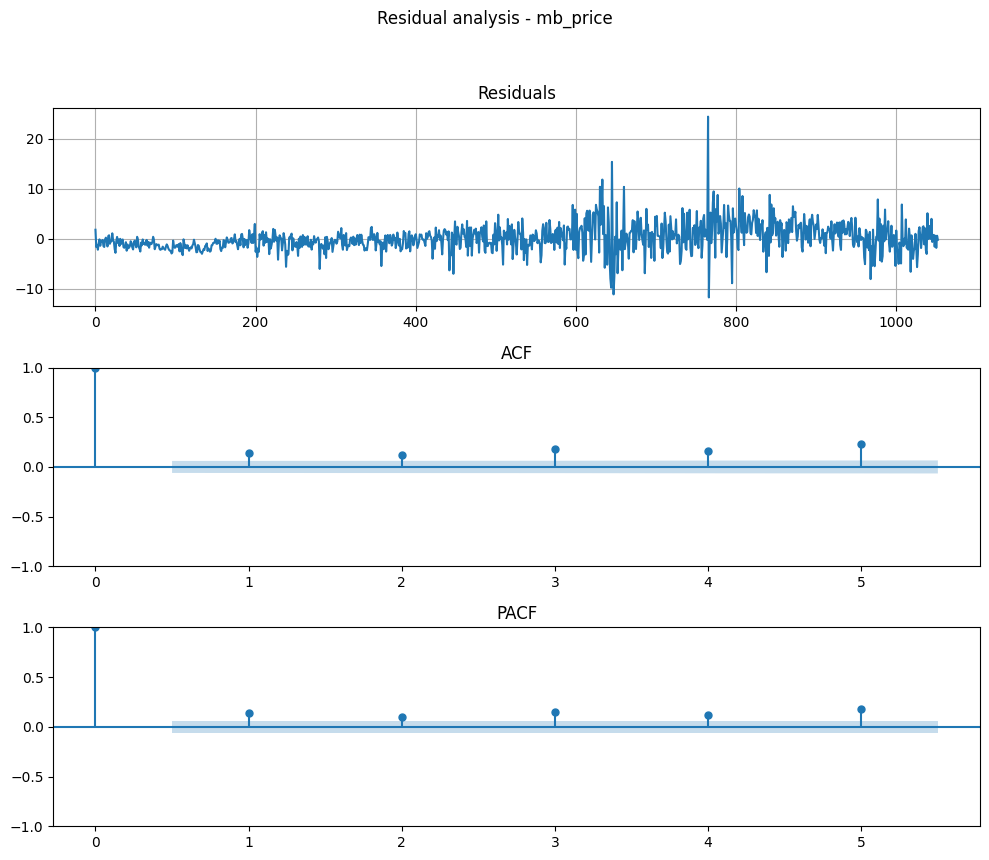


📊 Prueba de Ljung-Box para mb_price (lag=5):
❌ Hay autocorrelación (p ≤ 0.05).

📄 Análisis de residuos guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/residuos_train_No_ARCH_S0_5.pdf


In [ ]:
# Analizar residuos en entrenamiento (¿Capturó toda la dinámica temporal del pasado?)
resultados_residuos_train = analizar_residuos_modelo(
    y_real=y_real_rec_train,
    y_pred=y_pred_rec_train,
    nombres_columnas = columnas_objetivo,
    lags = horizon,
    guardar_pdf=True,
    ruta_pdf=ruta + f"/residuos_train_{vol}_{id_model}_{horizon}.pdf"
)

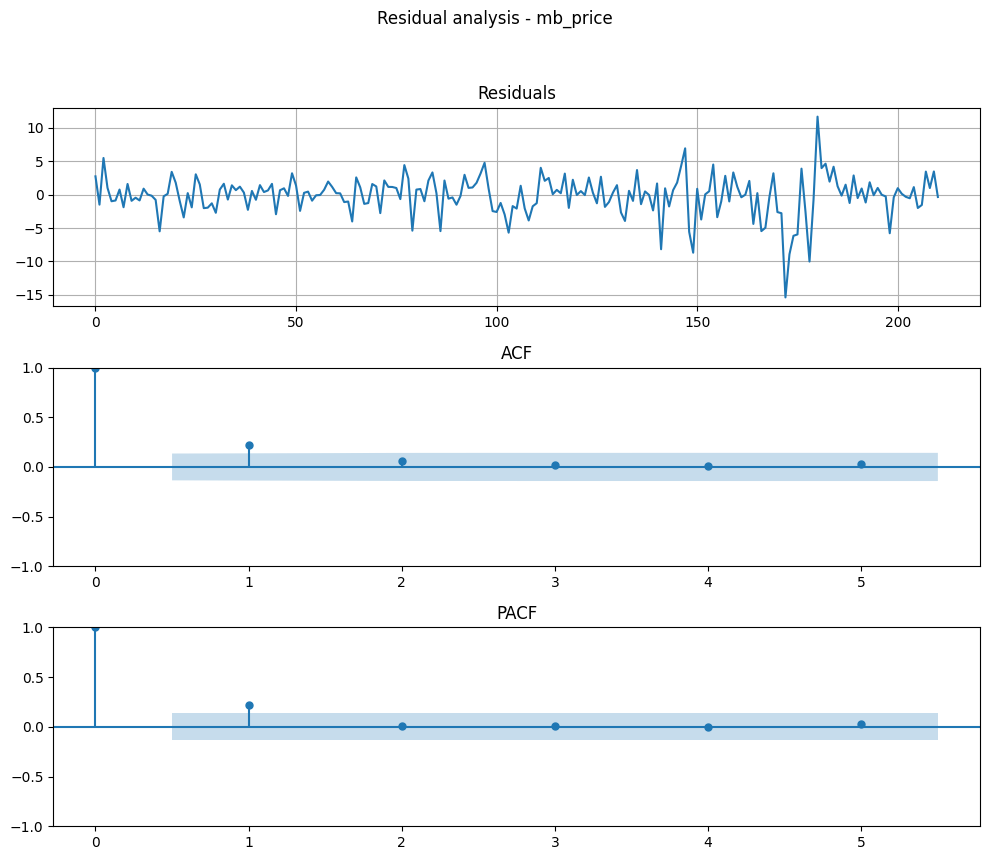


📊 Prueba de Ljung-Box para mb_price (lag=5):
❌ Hay autocorrelación (p ≤ 0.05).

📄 Análisis de residuos guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/residuos_val_No_ARCH_S0_5.pdf


In [ ]:
# Analizar residuos en validación
resultados_residuos_val = analizar_residuos_modelo(
    y_real=y_real_rec_val,
    y_pred=y_pred_rec_val,
    nombres_columnas = columnas_objetivo,
    lags = horizon,
    guardar_pdf=True,
    ruta_pdf=ruta + f"/residuos_val_{vol}_{id_model}_{horizon}.pdf"
)

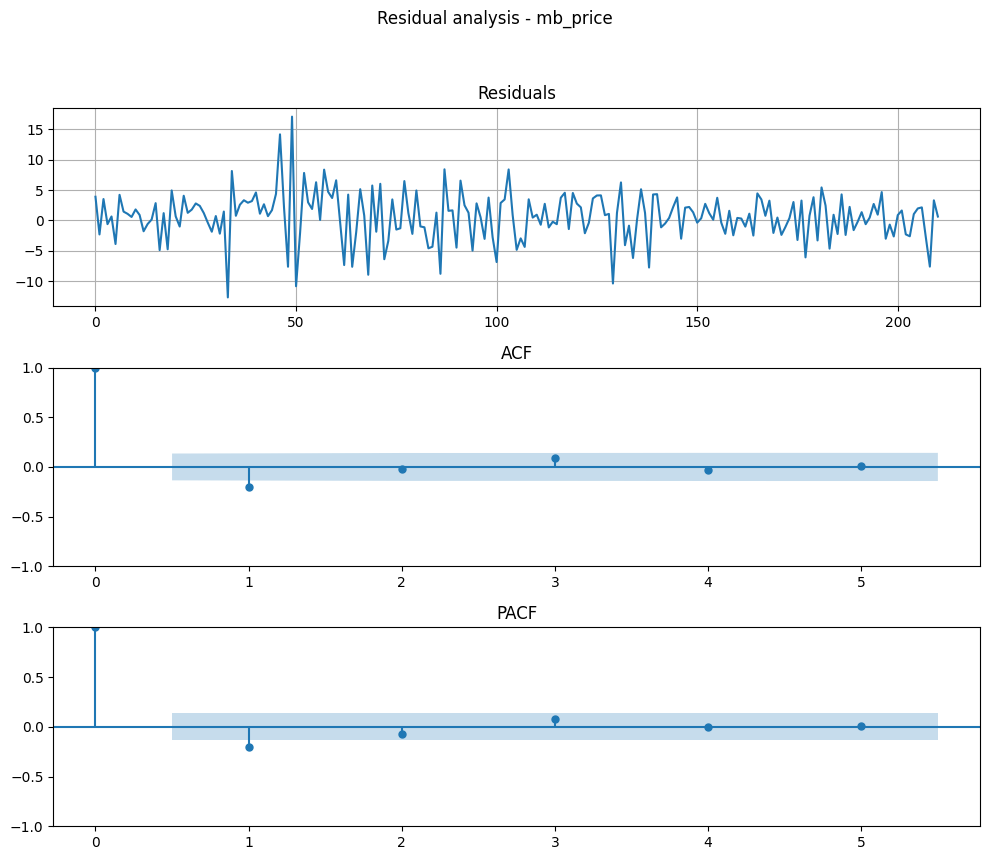


📊 Prueba de Ljung-Box para mb_price (lag=5):
✅ No hay autocorrelación significativa (p > 0.05).

📄 Análisis de residuos guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/residuos_test_No_ARCH_S0_5.pdf


In [ ]:
# Analizar residuos en test (Poder predictivo)
resultados_residuos_test = analizar_residuos_modelo(
    y_real=y_real_rec_test,
    y_pred=y_pred_rec_test,
    nombres_columnas = columnas_objetivo,
    lags = horizon,
    guardar_pdf=True,
    ruta_pdf=ruta + f"/residuos_test_{vol}_{id_model}_{horizon}.pdf"
)

## Mapas de saliencia

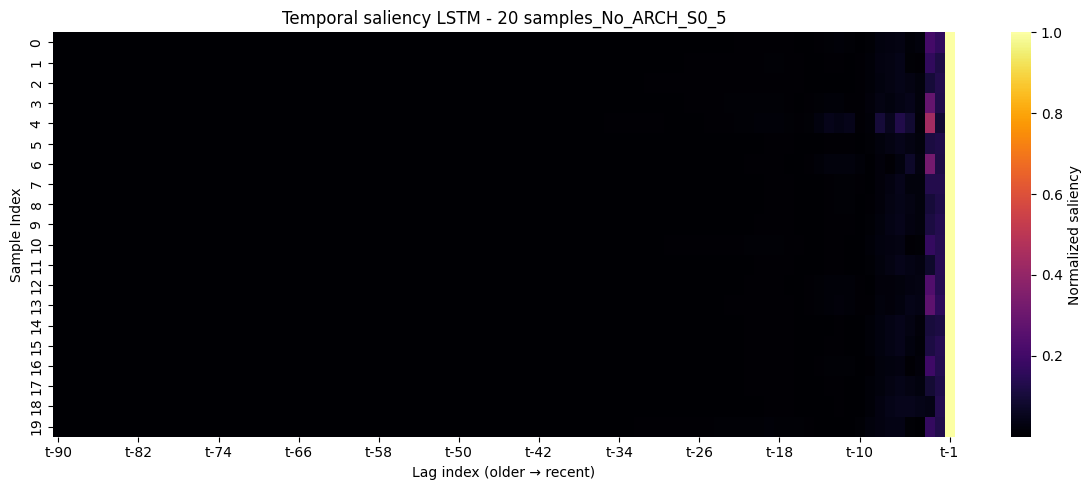

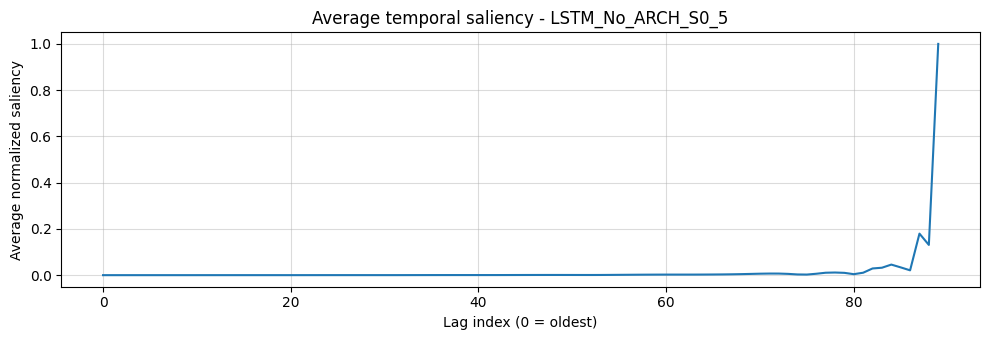

In [ ]:
# 1) Heatmap BxL con algunas muestras (ej. 20)
indices_heatmap = np.random.choice(test_sequences.shape[0], 20, replace=False)
X_heat = test_sequences[indices_heatmap]

_ = calcular_y_graficar_saliencia(
    model_LSTM,
    X_heat,
    device,
    horizon_idx=horizon-1,          # index starts in 0, so for h=22--horizon-1
    target_idx=0,
    titulo=f"Temporal saliency LSTM - 20 samples_{vol}_{id_model}_{horizon}",
    guardar_en=ruta,
    mostrar=True
)

# 2) Saliencia promedio con muchas muestras (ej. 300)
num_muestras = min(test_sequences.shape[0], 300)
indices_avg = np.random.choice(test_sequences.shape[0], num_muestras, replace=False)
X_avg = test_sequences[indices_avg]

sal_matrix = calcular_y_graficar_saliencia(
    model_LSTM,
    X_avg,
    device,
    horizon_idx=horizon-1,
    target_idx=0,
    mostrar=False      # ahora solo queremos los datos
)

sal_media = sal_matrix.mean(axis=0)  # (L,)

# 3) Graficar la curva promedio
L = sal_media.shape[0]
plt.figure(figsize=(10, 3.5))
plt.plot(range(L), sal_media)
plt.title(f"Average temporal saliency - LSTM_{vol}_{id_model}_{horizon}")
plt.xlabel("Lag index (0 = oldest)")
plt.ylabel("Average normalized saliency")
plt.grid(True, alpha=0.45)
plt.tight_layout()
plt.savefig(ruta + f"/saliencia_promedio_LSTM_{vol}_{id_model}_{horizon}.png", dpi=300)
plt.show()



## Visualización de la atención temporal

In [ ]:
# Atención en el conjunto de validación
#for i in range(0, len(val_sequences), 20):   # cada n ventanas, para no saturar
#    seq_i = val_sequences[i].unsqueeze(0)   # (1, L, F)
#    get_one_attention_curve(model_LSTM, seq_i,
#                            title=f"Attention – window {i}/{len(val_sequences)}")

In [ ]:
# Mapa de calor para visualizar en que tiempo (de n secuencias) pone atención la red
# en el conjunto de validación

#val_dataset = TensorDataset(val_sequences, val_labels)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#plot_attention_heatmap(model_LSTM, val_loader, n_muestras=15, title="Attention map (val)")



In [ ]:
# Atención en el conjunto de prueba

#for i in range(0, len(test_sequences), 20):   # cada n ventanas, para no saturar
#    seq_i = test_sequences[i].unsqueeze(0)   # (1, L, F)
#    get_one_attention_curve(model_LSTM, seq_i,
#                            title=f"Atenttion – window {i}/{len(test_sequences)}")


In [ ]:
# Mapa de calor para visualizar en que tiempo (de n secuencias) pone atención la red
# en el conjunto de prueba

#test_dataset = TensorDataset(test_sequences, test_labels)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#plot_attention_heatmap(model_LSTM, test_loader, n_muestras=15, title="Attention_map (test)")

## Backtesting

In [ ]:
# Párametros extras requeridos para correr el backtesting
# Todo el conjunto de datos ESTANDARIZADO
std_df = pd.concat([train_std_series, val_std_series, test_std_series], axis=0)
print(f'Tamaño de z_df: {std_df.shape}')
print(type(std_df))

# Indices
idx_train_end = len(train_std_series)
idx_val_end = idx_train_end + len(val_std_series)

print(f"idx train: {idx_train_end}")
print(f"idx val: {idx_val_end}")

Tamaño de z_df: (7651, 1)
<class 'pandas.core.frame.DataFrame'>
idx train: 5355
idx val: 6502


In [ ]:
# Ejecutando backtesting sin entrenamiento
window=600

res_back = backtesting_multistep_flexible(
    series_total_std = std_df,
    scaler           = scaler,
    modelo_base      = model_LSTM,          # nn.Module ya entrenado
    entrenar_fn      = entrenar_wrapper,
    predecir_fn      = predecir_fn,

    L=sequence_length, H=horizon, stride=stride,
    label_cols=label_cols,
    idx_train_end=idx_train_end,
    idx_val_end=idx_val_end,

    context_mode="rolling",             # 'expanding'|'rolling'|'train'|'val'|'last_n'
    context_W=window,                      # >= L+H (cumple)

    reentrenar=False,
    init_desde_base="clonar_base",
    reentrenar_cada = 10,             # reentrenar cada k ventanas
    warm_start = False,              # Parte de pesos de la ventana anterior

    # Ajusta estos hiperparámetros reales de tu entrenamiento:
    opciones_entrenamiento={
        "epochs": 12,
        "batch_size": 32,           # 16, 32, 64
        "learning_rate": 1e-4,    # 1e-2, 1e-3, 1e-4
        "patience": 8,
        # Si quieres validación desde el contexto (último 10%):
        "val_split": 0.10,         # 10% del contexto como val
        "min_val": 64              # asegura al menos 64 muestras en val
    },

    resolver_solapes="last"
)


In [ ]:
# Longitud de las predicciones
longitud_predicciones = len(res_back['flat']['y_pred'])

print("Total de predicciones generadas:", longitud_predicciones)

Total de predicciones generadas: 1145


In [ ]:
#print(res_back)

## Análisis de los residuos del backtesting

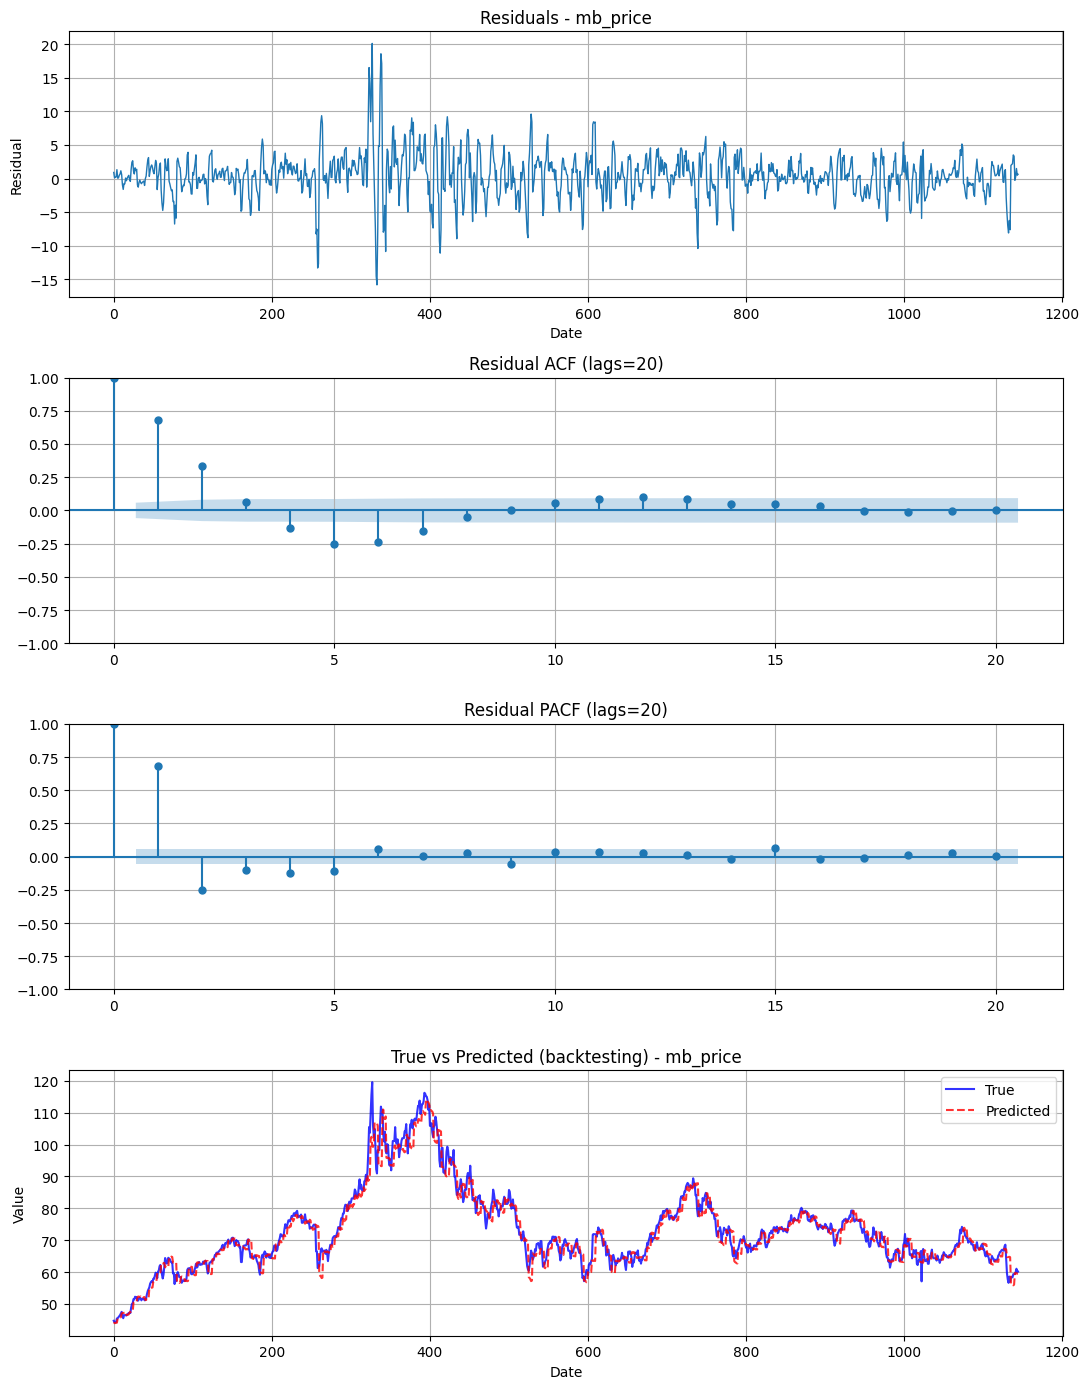

📄 PDF guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/residuos_backtest_No_ARCH_S0_5.pdf
📄 CSV de resumen guardado en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/resumen_residuos_backtest_No_ARCH_S0_5.csv


In [ ]:
metricas_bt = analizar_residuos_backtesting(
    y_real = res_back['flat']['y_real'],
    y_pred = res_back['flat']['y_pred'],
    nombres_columnas = columnas_objetivo,
    lags = 20,
    guardar_pdf=True,
    ruta_pdf = ruta + f"/residuos_backtest_{vol}_{id_model}_{horizon}.pdf",
    guardar_csv = True,
    ruta_csv = ruta + f"/resumen_residuos_backtest_{vol}_{id_model}_{horizon}.csv"
)

In [ ]:
metricas_bt

,Variable,N_efectivo,MAE,RMSE,R2,Ljung-Box p-value,Conclusión
0,mb_price,1145,2.278772,3.283576,0.93541,0.0,Autocorrelación significativa


## Modelo de persistencia
🔁 Modelo de Persistencia en Series Temporales

El modelo de **persistencia** es una técnica de predicción ingenua que asume que el valor futuro será igual al último valor observado. Matemáticamente:

$$
\hat{y}_{t+h} = y_t
$$

A diferencia de un modelo que predice un **valor constante** fijo, el modelo de persistencia **varía en el tiempo**, adaptándose al último valor conocido de la serie.


In [ ]:
# === Reconstruye los t0 del backtesting ===
T = len(std_df)
L=sequence_length
t0_start = max(idx_val_end, L)                     # igual que en backtesting
t0_end   = T - horizon
t0_bt = list(range(t0_start, t0_end + 1, stride))  # mismos cortes

# === Persistencia alineada EXACTAMENTE al calendario del backtesting ===
res_per = modelo_persistencia(
    test_series=std_df,
    sequence_length=sequence_length,
    h=horizon,
    label_cols=label_cols,
    scaler=scaler,
    stride=stride,
    resolver_solapes="first",
    t0_indices=t0_bt
    )

In [ ]:
# Longitud de las predicciones
long_preds_persistencia = len(res_per['panel']['Yhat_win'])

print("Total de predicciones generadas:", long_preds_persistencia)

Total de predicciones generadas: 229


## Comparación backtesting LSTM vs Persistencia

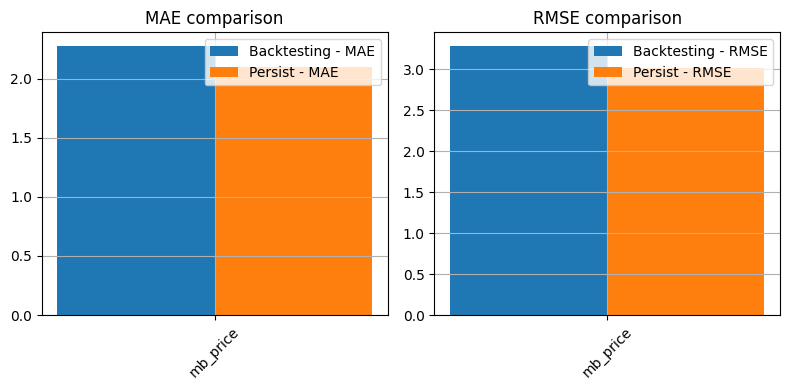

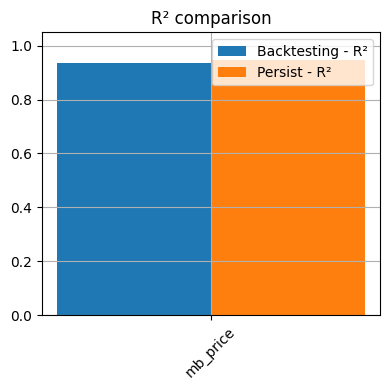

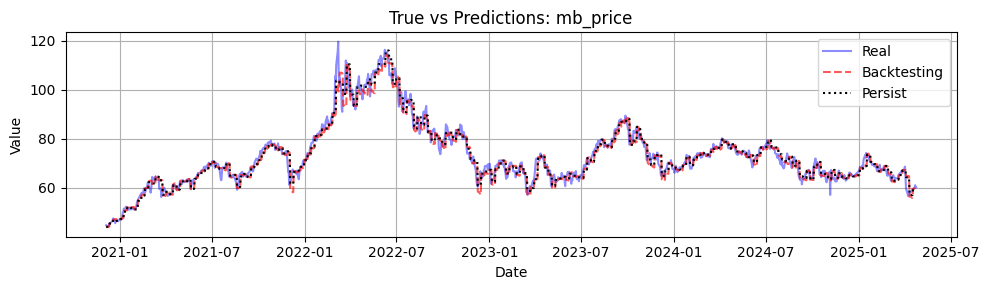

In [ ]:
# Evaluar las predicciones en test entre el backtesting y el modelo de persistencia
resumen_LSTM_vs_per = evaluar_backtesting_persistencia(
    res_back,
    res_per,
    h=horizon,
    nombres_columnas=list(serie_original.columns),
    ruta_series=ruta
    )

In [ ]:
resumen_LSTM_vs_per

,Variable,N_obs,Backtesting_MAE,Backtesting_RMSE,Backtesting_R2,Persist_MAE,Persist_RMSE,Persist_R2,DM_stat,DM_pvalue,DM_mean_d,Winner(mean loss),Significant(α=0.05)
0,mb_price,1145,2.278772,3.283576,0.93541,2.097851,3.018401,0.945421,2.776011,0.005503,1.671124,Persist,Yes


In [ ]:
# ¿Estan perfectamente alineadas las fechas para comparar
# backtesting vs persistencia?
Fechas_lstm = res_back["panel"]["Fechas_win"]
Fechas_per  = res_per["panel"]["Fechas_win"]  # perdón, Fechas_win
np.testing.assert_array_equal(Fechas_lstm, Fechas_per)


## Calibración conformal

1) Residuos del backtesting
*   res = Yreal_win - Yhat_win

2) Volatilidad condicional (GARCH)
*   sigma = generar_sigma_multi_desde_backtesting(...)

3) Residuos normalizados
*   z = res / sigma

4) Bootstrap empírico
*   Muestreos sobre z → percentiles por horizonte.

5) Intervalos calibrados
*   lower = y_hat + sigma * p_lower
*   upper = y_hat + sigma * p_upper

6) Métricas de calibración
*   Coverage, sharpness, Kupiec, Christoffersen.

7) Visualización
*   Gráficas: real vs pred, intervalos 80%/95%.


In [ ]:
# Validacion de la cobertura real para cada horizonte
# 0) Insumos del backtesting
Yhat_win = res_back["panel"]["Yhat_win"]   # (N,H,D) desescalado
Yreal_win = res_back["panel"]["Yreal_win"] # (N,H,D)

# 1) Ejecuta SOLO el wrapper, pasando parámetros coherentes con tu decisión:
#    Aquí: GARCH en retornos, con media cero.

low, high, cob_global_bt, cob_h_bt, q_info = conformal_en_backtesting_split(
    backtesting_result=res_back,
    series_original=serie_original,          # escala original
    columnas_objetivo=columnas_objetivo,
    alpha=0.05,
    metodo="estandarizado",                  # adaptativo
    h=Yhat_win.shape[1],                     # asegura mismo H
    mean="Zero", vol="GARCH", p_g=1, o_g=0, q_g=1,
    # EGARCH si el pasado cercano es muy volatil, sino GARCH
    dist="t",
    min_obs=250,
    usar_retornos=True,
    usar_iqr=False,                          # mantén garantía exacta
    resolver="mean",
    frac_cal=0.7,                            # n% para calibración
    ventana_garch=504,
)

In [ ]:
# Cobertura empírica
print("Cobertura empírica por variable y horizonte (objetivo 95%):")
display(cob_h_bt)
display(cob_global_bt)

Cobertura empírica por variable y horizonte (objetivo 95%):


array([[0.94202899],
       [0.92753623],
       [0.91304348],
       [1.        ],
       [0.95652174]])

,0
mb_price,0.947826


In [ ]:
# Ancho promedio del intervalo
q_df = pd.DataFrame(
    q_info["q"],
    columns=q_info["columnas"],
    index=[f"h={h}" for h in q_info["horizontes"]]
)
display(q_df)

,mb_price
h=1,1.783490
h=2,2.666422
h=3,3.338141
h=4,4.599761
h=5,3.997246


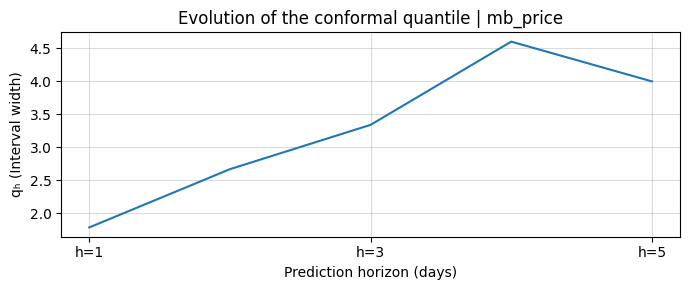

In [ ]:
# Evolución del cuanti conformal - medida de incertidumbre medida en sigmas
for series in q_df.columns:
    fig, ax = plt.subplots(figsize=(7,3))
    ax.plot(q_df[series])
    ax.set_title(f"Evolution of the conformal quantile | {series}")
    ax.set_xlabel("Prediction horizon (days)")
    ax.set_ylabel("qₕ (Interval width)")
    ax.grid(True, alpha=0.45)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig.tight_layout()
    plt.show()

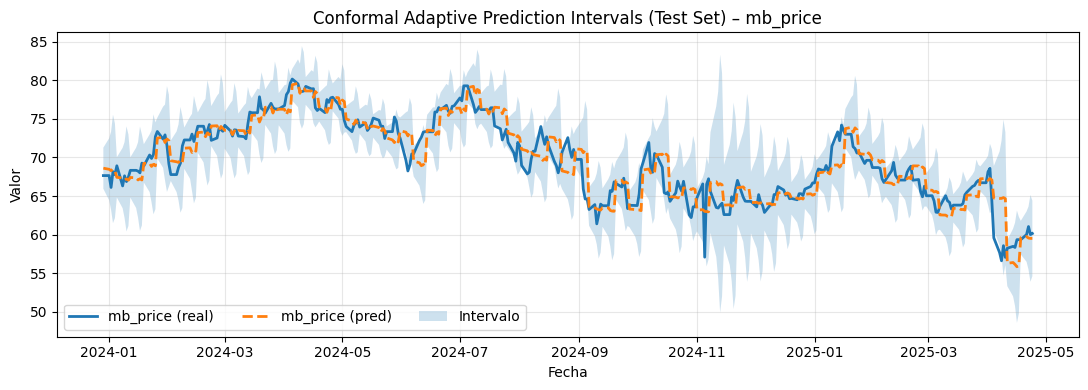

In [ ]:
# 1) Aplana backtesting con el MISMO 'resolver' usado en conformal
y_pred_flat = _flatten_by_date(res_back["panel"]["Yhat_win"], res_back["panel"]["Fechas_win"],
                               list(serie_original.columns), resolver="mean")                      # Usa serie(s)_original(es)
y_real_flat = _flatten_by_date(res_back["panel"]["Yreal_win"], res_back["panel"]["Fechas_win"],
                               list(serie_original.columns), resolver="mean")

# 2) Grafica por columnas objetivo
for c in columnas_objetivo:
    plot_bt_con_bandas(
        y_real_flat=y_real_flat[[c]],
        y_pred_flat=y_pred_flat[[c]],
        low=low[[c]],
        high=high[[c]],
        titulo=f"Conformal Adaptive Prediction Intervals (Test Set) – {c}",
        ruta_png=ruta + f"/intervalos_backtesting_{c}_{vol}_{id_model}_{horizon}.png"
    )


In [ ]:
# Resumen de las metricas
resumen_bt = resumen_intervalos(y_real_flat, low, high)
winkler_bt = winkler_score(y_real_flat, low, high, alpha=0.05)
tests_interp_bt = tests_cobertura_con_interpretacion(y_real_flat, low, high, alpha=0.05)

display(resumen_bt)
display(winkler_bt)   # utilidad (menor es mejor)
display(tests_interp_bt)

#Decision_POF: Aceptar H0 (cobertura ≈ α)
#Decision_IND: Rechazar H0 (clustering)
#Decision_CC: Rechazar H0 (cobertura condicional)

,coverage,avg_width,p_under,p_over,n,violations
mb_price,0.947826,8.990336,0.026087,0.026087,345,18


,winkler_score
mb_price,10.155139


,LR_POF,p_POF,Decision_POF,LR_IND,p_IND,Decision_IND,LR_CC,p_CC,Decision_CC,Diagnostico
variable,,,,,,,,,,
mb_price,0.033864,0.832379,Aceptar H0,10.735451,0.001224,Rechazar H0,10.769315,0.004777,Rechazar H0,"Cobertura correcta, pero violaciones con clust..."


In [ ]:
# Guardar cada conformal backtesting para cada serie
with pd.ExcelWriter(ruta + f"/conformal_backtesting_multiserie_{vol}_{id_model}_{horizon}.xlsx") as writer:
    for col in columnas_objetivo:
        df_col = pd.concat({
            "low": low[col],
            "high": high[col],
            "real": y_real_flat[col],
            "pred": y_pred_flat[col]
        }, axis=1)
        df_col.to_excel(writer, sheet_name=col[:30])  # Excel limita a 31 caracteres por hoja

print(f"Archivo guardado con {len(columnas_objetivo)} hojas en: {ruta}")

Archivo guardado con 1 hojas en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5


## Módulo económico Backtesting

In [ ]:
# muestras_pred es la versión “distribucional” de esas predicciones
# en lugar de un solo número por (ventana, horizonte),
# tienes K muestras

sigma_hist, z_hist = generar_sigma_multi_desde_backtesting(
    backtesting_result= res_back,
    series_original = serie_original,
    columnas_objetivo= columnas_objetivo,
    h=horizon,
    mean= "Zero",
    vol= "GARCH",
    p=1, o=0, q= 1,
    dist= "t",
    min_obs=250,
    usar_retornos= True,
    show_warnings= False,
    ventana_garch = 504
    )

muestras_pred = generar_muestras_pred_bootstrap_multi(
    Yhat=Yhat_win,            # (N,H,D)
    sigma_hist=sigma_hist,    # (N,H,D)
    z_hist=z_hist,            # (M,) o (M,D)
    K=1000
)

fila = evaluar_modulo_economico_backtesting(
    res_back=res_back,
    nombre_modelo=f"LSTM_{vol}_{id_model}_{horizon}",
    escenario="Backtesting",
    horizonte=Yhat_win.shape[1],
    columnas_objetivo=list(serie_original.columns),
    sigma_pred=sigma_hist,
    muestras_pred=muestras_pred,   # si ya las tienes
    y_persist=res_per['panel']['Yhat_win'],
)


In [ ]:
display(fila)

{'modelo': 'LSTM_No_ARCH_S0_5',
 'escenario': 'Backtesting',
 'horizonte': 5,
 'num_obs': 229,
 'num_objetivos': 1,
 'QLIKE': 3.323121168408847,
 'CRPS': 4.76383196362835,
 'valor_econ_total': -207.15428161621094,
 'valor_econ_medio': -0.1809207648038864,
 'mae_modelo': 2.2787721157073975,
 'mae_persist': 2.097851276397705,
 'coverage_0.8': 0.9502183406113537,
 'ES_mean_0.8': 77.49290903992687,
 'coverage_0.95': 0.9493449781659389,
 'ES_mean_0.95': 77.49087755200745,
 'target_0': 'mb_price'}

## Predicción futura real

### Predicción

In [ ]:
ruta_futuro = ruta + '/Prediccion_futuro_real'

[Predicción] modo=directo | h=5 | out_dim=1 | fechas=2025-05-01 00:00:00→2025-05-07 00:00:00


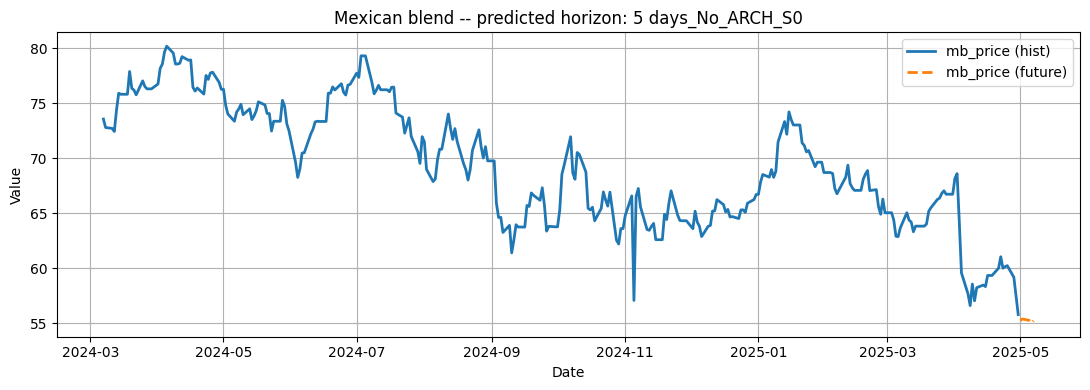

[Atención] No se detectaron pesos de atención en el modelo.
{'ruta_png': '/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/Prediccion_futuro_real.png', 'ruta_csv': '/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/Prediccion_futuro_real.csv', 'att_csv': None, 'att_png': None}


In [ ]:
# Ejecutar pipeline para la predicción futura
#horizon = #
config = {
    "scaler": scaler,
    "sequence_length": sequence_length,
    "h": horizon ,                            # ← horizonte futuro deseado (horizon o n > 1)
    "label_cols": label_cols,
    "crear_secuencias_fn": create_multichannel_label_sequences,
    "entrenar_fn": entrenar_wrapper,
    "reentrenar": False,
    "freeze_policy": "auto",
    "freeze_patterns": ("lstm",),
    "auto_threshold": 2000,
    "warm_start": False,
    "warm_state_dict": None,
    "window_size": window,
    "num_epochs": 15,
    "batch_size": 64,
    "learning_rate": 1e-4,
    # Si reentrenar = True:
      # y usas modo directo usar learning_rate = 1e-6
      # o modo recursivo_bloque usar learning_rate = 1e-4
    "modo_prediccion": "directo",            # directo, recursivo, recursivo_bloque
    "nombres_columnas": list(serie_original.columns),
    "devolver_atencion": True,
    "mostrar_logging": True,
}

salida = pipeline_prediccion_futuro(
    modelo_entrenado=model_LSTM,
    series_estandarizadas=std_df,
    config=config,
    ruta_base=ruta_futuro,
    ultimos_n_historico=300,
    titulo_grafica=f"Mexican blend -- predicted horizon: {horizon} days_{vol}_{id_model}",
)

print(salida["archivos"])

# Extracción de salida la predicción futura real
y_pred_f_mm = (salida['resultado_pred']['y_pred']['mb_price'])
#y_pred_f_wti= (salida['resultado_pred']['y_pred']['wti_price'])

In [ ]:
#warm_state_dict

In [ ]:
# Verificar que contiene la salida y en que formato
#salida

### Predicción futura con intervalos conformales

In [ ]:
historico_df = reconstruir_historico_desescalado(
    series_totales=std_df,                       # DF estándarizado
    scaler=scaler,
    label_cols=label_cols,                       # índices o nombres
    ultimos_n=300,                               # p.ej. 200
    nombres_columnas=config.get("nombres_columnas")  # opcional
)


In [ ]:
#historico_df.describe()

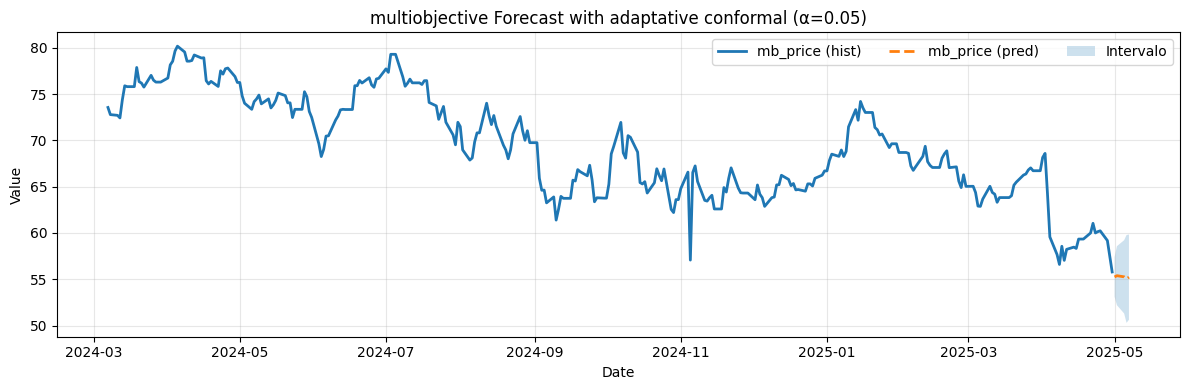

In [ ]:
# 1) Extraer la predicción futura del diccionaria de salida
y_pred_df = salida['resultado_pred']['y_pred'].copy()
y_pred_df.index = salida['resultado_pred']['fechas']


# 2) Ventana para calcular volatilidad GARCH
ventana_garch = 504

# ============================================
# Intervalos adaptativos para FUTURO (niveles)
# ============================================

# Insumos:
# - res_back: resultado del backtesting (con panel)
# - serie_original: DataFrame en escala original (ej. ['mb_price'])
# - y_pred_df: predicciones futuras (H,D) desescaladas, índice = fechas futuras
# - historico_df: histórico previo alineado (T0,D) desescalado
low_df, high_df, q_info_fut = conformal_adaptativo_desde_bt(
    backtesting_result=res_back,
    series_original=serie_original,
    y_pred_df=y_pred_df,
    historico_df=historico_df,
    columnas_objetivo=columnas_objetivo,
    alpha=0.05,
    h=y_pred_df.shape[0],
    mean="Zero", vol="GARCH", p=1, o=0, q=1, dist="t",
    min_obs=250,
    usar_retornos=True,
    usar_iqr=False,
    show_warnings=False,
    ruta_png=ruta_futuro,
    ventana_garch=ventana_garch

)

In [ ]:
# (opcional) ver primeras filas
print('Precio mínimo esperado:')
display(low_df.head())
print('Precio máximo esperado:')
display(high_df.head())

Precio mínimo esperado:


,mb_price
2025-05-01,53.111360
2025-05-02,52.193952
2025-05-05,51.303066
2025-05-06,50.288940
2025-05-07,50.624727


Precio máximo esperado:


,mb_price
2025-05-01,57.391830
2025-05-02,58.575366
2025-05-05,59.220501
2025-05-06,59.775414
2025-05-07,59.833014


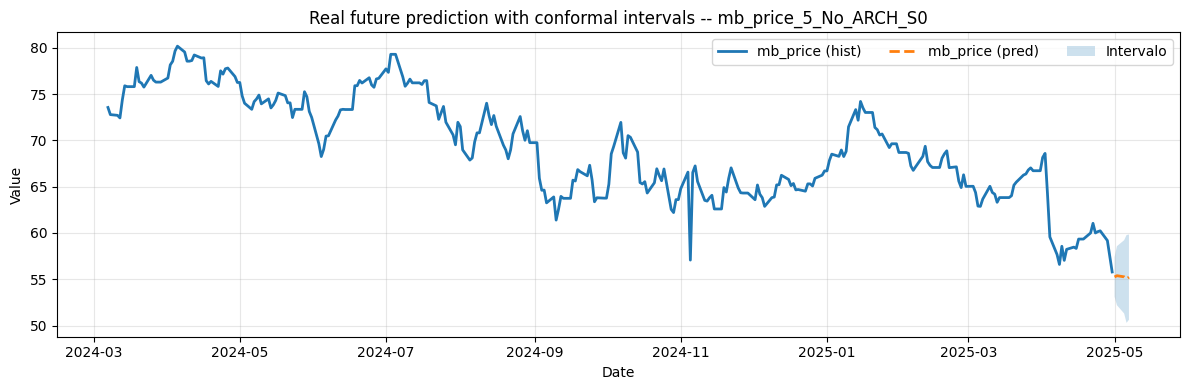

In [ ]:
# (Opcional) Gráfica rápida:
for c in columnas_objetivo:
    plot_multiserie_con_bandas(
        historico_df=historico_df[[c]],   # pasado
        y_pred_df=y_pred_df[[c]],         # futuro
        low_df=low_df[[c]],
        high_df=high_df[[c]],
        titulo=f"Real future prediction with conformal intervals -- {c}_{horizon}_{vol}_{id_model}",
        ruta_png=ruta_futuro + f"/futuro_con_intervalos_{c}_{horizon}_{vol}_{id_model}.png"
    )


### Visualización de la predicción real futura vs lo real (reportado)

In [ ]:
# Lectura de los precios reales en el futuro reportados
y_reales_f = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/Predicciones_finales/Comparacion final entre precios/precios_reales_mayo_2025_futuro.xlsx', index_col=0)
y_real_f_mm = y_reales_f['mb_price'].to_frame()
y_real_f_wti = y_reales_f['wti_price'].to_frame()


In [ ]:
y_futuro_mm = pd.concat([y_real_f_mm, y_pred_f_mm], axis=1)

# Guardammos precios reales y predicciones
y_futuro_mm = y_futuro_mm.rename(columns={0: 'Real', 1: 'Predicción'})
y_futuro_mm.to_excel(ruta_futuro + f'/futuro_real_vs_predicho_{id_model}_{vol}_horizonte{horizon}.xlsx', index=True)

In [ ]:
y_futuro_mm.head(horizon)


,mb_price,mb_price
2025-05-01,55.79,55.251595
2025-05-02,54.68,55.384659
2025-05-05,54.68,55.261784
2025-05-06,55.33,55.032177
2025-05-07,54.73,55.228870


In [ ]:
#display(q_info_fut)


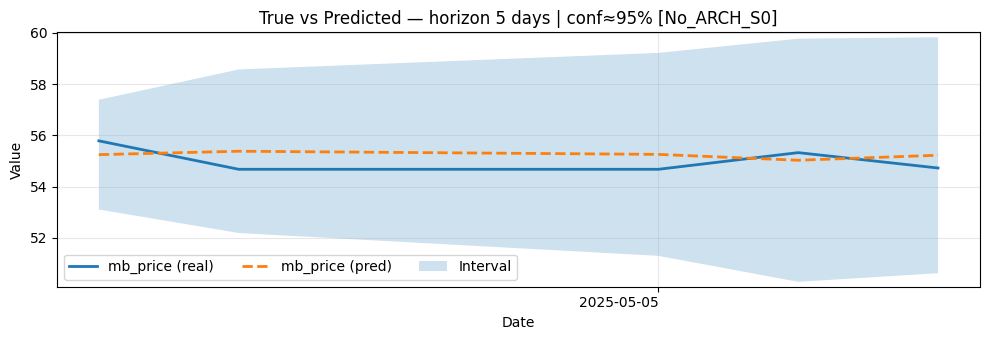

✅ Figura guardada en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/Prediccion_futuro_real/futuro_5_No_ARCH_S0_con_bandas.png


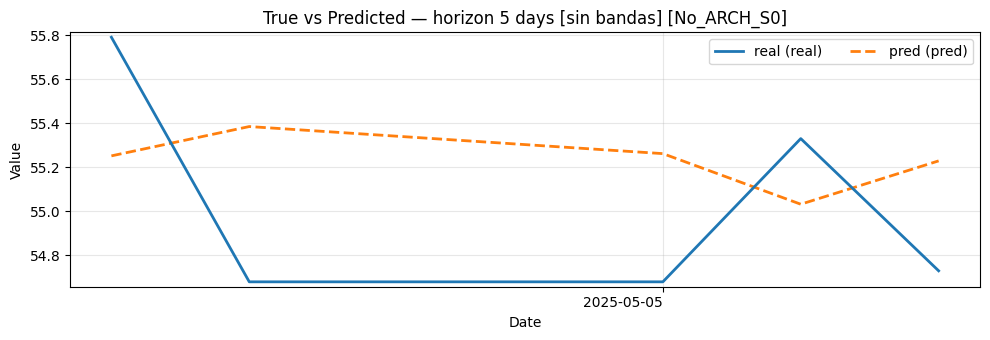

In [ ]:
#low_df, high_df, q_info = conformal_adaptativo_desde_bt(...)
# Prediccion vs real futura con bandas
plot_futuro_dual(
    y_future_true=y_real_f_mm[:horizon],
    y_future_predicted=y_pred_f_mm,
    low_df=low_df,
    high_df=high_df,
    q_info=q_info_fut,
    horizon=horizon,
    vol=vol,
    model_id=id_model,
    save=True,
    path=ruta_futuro,
    name_base=f"futuro_{horizon}_{vol}_{id_model}"
)


### Métricas de la calibración probabilística del futuro







In [ ]:
# Resumen de las metricas
resumen_fut = resumen_intervalos(y_real_f_mm, low_df, high_df)
winkler_fut = winkler_score(y_real_f_mm, low_df, high_df, alpha=0.05)
tests_interp_fut = tests_cobertura_con_interpretacion(y_real_f_mm, low_df, high_df, alpha=0.05)

display(resumen_fut)
display(winkler_fut)   # utilidad (menor es mejor)
display(tests_interp_fut)

#Decision_POF: Aceptar H0 (cobertura ≈ α)
#Decision_IND: Rechazar H0 (clustering)
#Decision_CC: Rechazar H0 (cobertura condicional)


,coverage,avg_width,p_under,p_over,n,violations
mb_price,1.0,7.454816,0.0,0.0,5,0


,winkler_score
mb_price,7.454816


,LR_POF,p_POF,Decision_POF,LR_IND,p_IND,Decision_IND,LR_CC,p_CC,Decision_CC,Diagnostico
variable,,,,,,,,,,
mb_price,1.397787,0.235169,Aceptar H0,-0.0,0.95052,Aceptar H0,1.397787,0.501739,Aceptar H0,Cobertura correcta e independencia (bien calib...


### Evaluación futuro real


🔍 Evaluación Modelo vs Persistencia
───────────────────────────────────────────
MAE modelo: 0.5243 | MAE persistencia: 0.7480
RMSE modelo: 0.5408 | RMSE persistencia: 0.8717
R² modelo: -0.4597
Skill (MAE): 29.91% | Skill (RMSE): 37.96%
MASE: 0.701
Direccionalidad (DA): modelo=0.000 | persistencia=0.250
Diebold–Mariano: stat=-0.000, p-value=1.000
🎯 Significancia estadística: No significativa


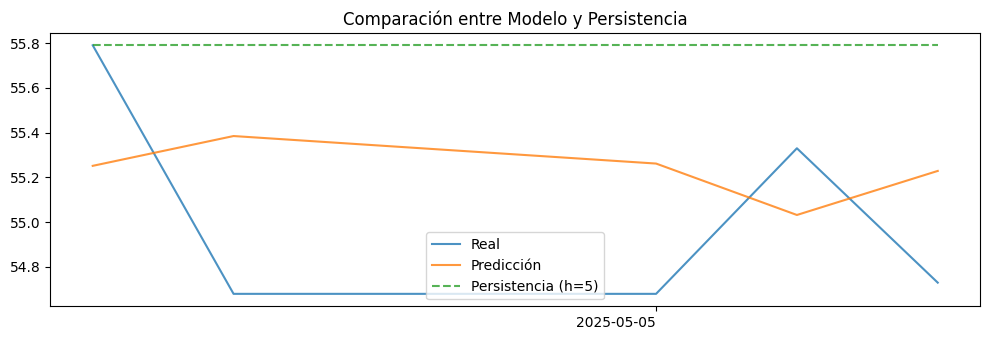


📊 Análisis complementario del ajuste:
Media de residuos: -0.1898
Desviación estándar de residuos: 0.5662
🧪 Ljung–Box (lag=10): stat=6.528, p-value=0.163
✅ Residuos sin autocorrelación significativa (independientes).
💾 Métricas guardadas en: /content/drive/MyDrive/Colab Notebooks/Energy thesis/Pytorch/Codigos finales tesis/LSTM and Hybrid models para Q1/Resultados/S0/Resultados_generales_h5/Prediccion_futuro_real/metrics_future_comparison_No_ARCH_S0_5.csv


In [ ]:
res, y_persist_goos = comparar_modelo_vs_persistencia(y_real=y_real_f_mm[:horizon],
                                      y_pred=y_pred_f_mm[:horizon],
                                      h=horizon,
                                      ruta_guardado=f'{ruta_futuro}/metrics_future_comparison_{vol}_{id_model}_{horizon}.csv')

## Guardado de artefactos

In [ ]:
# ============================================================
# Config y extras listos para enchufar a guardar_artefactos_pipeline
# (rellena los None y "TODO" según tu modelo)
# ============================================================

config = {
    # Identificación general
    "pipeline_version": "2_S0_LSTM_h5",   # p.ej. "LSTM_S0_h22"
    "scenario": "S0",                    # "S0", "S1" o "S2"
    "freq": "B",                         # "B", "D", "M", etc.

    # Estructura temporal
    "sequence_length": 90,             # ventana de entrada (lags)
    "horizon": 5,                     # h de este modelo (por claridad)

    # Preprocesamiento de la serie objetivo y features
    "data": {
        "use_log": False,                # si aplicaste log a la serie
        "diff_order": 0,                 # orden de diferenciación (0 si no)
        "use_returns": False,            # retornos log o simples

        # Resumen de tu función crea_caracteristicas_tecnicas
        "features_tecnicas": {
            "usar_logreturn": False,
            "usar_diff": False,
            "usar_SMA": False,
            "ventana_SMA": False,         # p.ej. 2*h
            "usar_STD": True,
            "ventana_STD": False,         # p.ej. 4*h
            "usar_ZScore": False,
            "ventana_ZScore": False,      # p.ej. 2*h
            "otras_features": "Ningua",    # si agregas algo más: RSI, max/min, etc.
        },
    },

    # Splits temporales
    "splits": {
        "fecha_ultimo_train": "1996-01-03",
        "fecha_inicio_val":   "2016-07-13",   # o None si no hay val explícita
        "fecha_inicio_test":  "2020-12-04",
        "n_train": 5355,
        "n_val": 1147,
        "n_test": 1149,
    },

    # Hiperparámetros de entrenamiento (no de arquitectura)
    "training": {
        "num_epochs": 500,
        "batch_size": 16,
        "learning_rate": 7e-4,
        "optimizer": "Adam",        # o el que uses
        "weight_decay": 0.0,
        "scheduler": "None",        # nombre o "None"
        "loss_fn": "MSELoss",       # o "HuberLoss", etc.
        "seed": 42,
        "early_stopping": {
            "patience": 80,
            "monitor": "val_loss",  # o la métrica que uses
        },
    },

    # Por conveniencia: nombres de columnas objetivo (además de label_cols)
    "label_names": "mb_price",  # p.ej. ["Precio_MB"]
}

extras = {
    # Backtesting / GOOS
    "backtesting": {
        "esquema": "walk_forward_multihorizon",
        "window_size_bt": 600,         # tamaño de ventana de entreno en bt
        "tipo_ventana": "rolling",     # "rolling" o "expanding"
        "stride": 5,                   # normalmente = h
        "horizontes_evaluados": 1,     # p.ej. [1, 5, 10, 20, 22, 30] o [h]
    },

    # Calibración y métricas de riesgo
    "calibracion": {
        "metodo_conformal": "split_conformal",   # o el que uses
        "niveles_alpha": [0.2, 0.05],            # 80% y 95%
        "ventana_calibracion": None,             # número de obs usadas
        "metricas_puntuales": ["MAE", "RMSE", "R2"],
        "metricas_riesgo":  ["QLIKE", "CRPS", "VaR", "ES"],
        "niveles_cobertura": [0.8, 0.95],
    },

    # Información del dataset
    "info_dataset": {
        "nombre_serie": "Mezcla Mexicana",
        "fuente": "Banco de México",
        "observaciones_totales": None,
        "periodo": "1996-01-03 a 2025-04-30",
    },

    # Notas suaves (interpretación, contexto)
    "comentarios": (
        "Modelo S0 con información limitada (sin features macro), "
        "especializado en horizonte corto h=1."
    ),
}

# ============================================================
# Ejemplo de uso (solo rellena config/extras y ejecuta):
# ============================================================
ruta_base = ruta + '/Artefactos'
ruta_base, ruta_base = guardar_artefactos_pipeline(
    model=model_LSTM,
    scaler=scaler,
    basepath=ruta_base + f"/artefactos_LSTM_{horizon}_{vol}_{id_model}",
    label_cols=label_cols,
    nombres_columnas=columnas_objetivo,
    config=config,
    extras=extras,
    versionado=True,
    guardar_diario=True     # ⬅️ aquí
)